## Importing Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
#Importing Necessary Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score,recall_score,precision_score,roc_auc_score,accuracy_score
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

## Data Preprocessing 

In [2]:
attrition_df = pd.read_csv('HR-Employee-Attrition.csv')
attrition_df = pd.get_dummies(attrition_df) #Convert categorical columns to discrete numbers
attrition_df = attrition_df.drop(['Attrition_No','Gender_Female','OverTime_No','EmployeeCount',
                                  'StandardHours','Over18_Y',
                                  'EmployeeNumber'],axis=1) #Dropping useless columns (Same value, ID, Extra Category)

attrition_df = attrition_df.rename(columns={"Attrition_Yes": "Attrition", "OverTime_Yes": "OverTime"}) 
#Because converted categorical columns change names, change binary categories back to their original names

y= attrition_df['Attrition']
X=attrition_df.drop('Attrition',axis=1) #Separate data into X and Y columns

non_numeric_cols = ['JobLevel','StockOptionLevel','BusinessTravel_Non-Travel','BusinessTravel_Travel_Frequently',
                    'BusinessTravel_Travel_Rarely','Department_Human Resources','Department_Research & Development',
                    'Department_Sales','EducationField_Human Resources','EducationField_Life Sciences',
                    'EducationField_Marketing','EducationField_Medical','EducationField_Other',
                    'EducationField_Technical Degree','Gender_Male','JobRole_Healthcare Representative',
                    'JobRole_Manufacturing Director','JobRole_Human Resources','JobRole_Laboratory Technician',
                    'JobRole_Manager','JobRole_Research Director','JobRole_Research Scientist','JobRole_Sales Executive',
                    'JobRole_Sales Representative','MaritalStatus_Divorced','MaritalStatus_Married','MaritalStatus_Single',
                    'OverTime','Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating',
                    'RelationshipSatisfaction','WorkLifeBalance'] #Categorical Columns

numeric_df = attrition_df.drop(non_numeric_cols, axis=1) #Dataframe with only numerical columns, including Y-column 'Attrition'

print(numeric_df.columns)



Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition'],
      dtype='object')


## Experimenting with Correlation

to_drop columns:  ['JobLevel', 'MonthlyIncome', 'PercentSalaryHike', 'YearsAtCompany', 'YearsInCurrentRole', 'BusinessTravel_Travel_Frequently', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales']


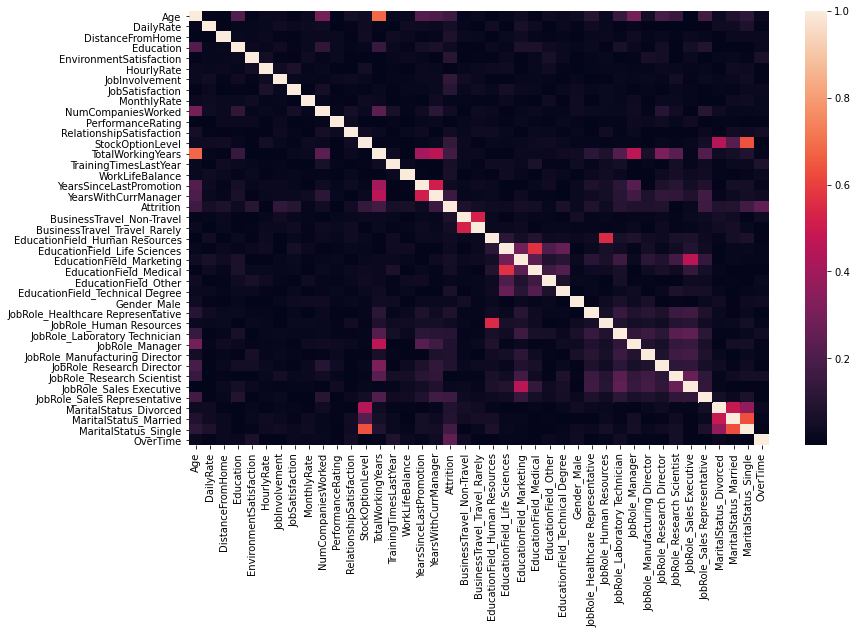

In [68]:
corr_mask = np.triu(np.ones_like(attrition_df.corr(), dtype=bool))
tri_df = attrition_df.corr().abs().mask(corr_mask)
plt.figure(figsize=(13,8))
#sns.heatmap(attrition_df.corr().abs(),mask=corr_mask,annot=True,fmt='.0%')
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.7)]
print('to_drop columns: ', to_drop)
df_exp = attrition_df.drop(to_drop, axis=1)
df_exp.corr()
sns.heatmap(df_exp.corr().abs(),annot=False,fmt='.0%')

X_corr= df_exp.drop('Attrition',axis=1)
y_corr=df_exp['Attrition']


## Data Visualization 

Text(0.5, 1.0, 'Attrition Rate Among Different Gender And Age Group')

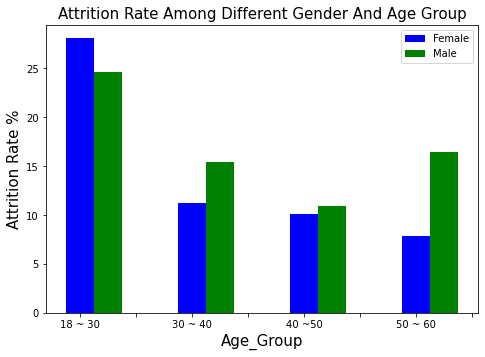

In [69]:
# make a copy of data
visual_x = attrition_df.copy()
# range of age
min(visual_x['Age'])
max(visual_x['Age'])
visual_x['Age_Group'] = 'a'
for i in range(len(visual_x['Age'])):
    if 18 <= visual_x['Age'][i] <= 30:
        visual_x['Age_Group'][i] = '18 ~ 30'
    elif 30 < visual_x['Age'][i] <= 40:
        visual_x['Age_Group'][i] = '30 ~ 40'
    elif 40 < visual_x['Age'][i] <= 50:
        visual_x['Age_Group'][i] = '40 ~ 50'
    else:
        visual_x['Age_Group'][i] = '50 ~ 60'


# Attrition Rate Among Different Gender And Age Group
groupped_data1 = visual_x[visual_x['Attrition'] == 1].groupby(["Gender_Male", "Age_Group"]).count()['Age']
groupped_data2 = visual_x.groupby(["Gender_Male", "Age_Group"]).count()['Age']
groupped_data = (groupped_data1/groupped_data2) * 100
labels = ['', '18 ~ 30', '', '30 ~ 40', '', '40 ~50', '', '50 ~ 60']
fig = plt.figure()
x_bar = np.arange(4)
ax = fig.add_axes([0,0,1,1])
ax.bar(x_bar + 0.00, groupped_data[0], color = 'b', width = 0.25)
ax.bar(x_bar + 0.25, groupped_data[1], color = 'g', width = 0.25)
ax.legend(labels=['Female', 'Male'])
ax.set_xticklabels(labels)
plt.xlabel('Age_Group', size = 15)
plt.ylabel('Attrition Rate %', size = 15)
plt.title('Attrition Rate Among Different Gender And Age Group', size = 15)


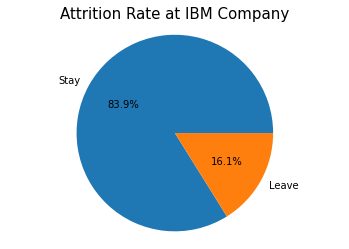

In [70]:
fig, ax = plt.subplots()
ax.pie(attrition_df["Attrition"].value_counts() ,labels=["Stay","Leave"],
       autopct='%1.1f%%')
ax.axis('equal')
plt.title('Attrition Rate at IBM Company', size = 15)
plt.show()

## Attrition Rate By Department

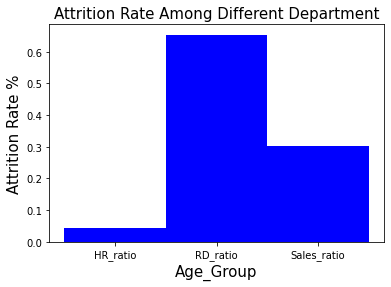

In [71]:
HR=attrition_df['Department_Human Resources'].sum()
RD=attrition_df['Department_Research & Development'].sum()
Sales=attrition_df['Department_Sales'].sum()
total=HR+RD+Sales
HR_ratio=HR/total
RD_ratio=RD/total
Sales_ratio=Sales/total
label = ['HR_ratio', 'RD_ratio', 'Sales_ratio']
ratio = [HR_ratio,RD_ratio,Sales_ratio]
pos = np.arange(len(label))
width = 1.0 
ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.bar(pos, ratio, width, color='b')
plt.xlabel('Age_Group', size = 15)
plt.ylabel('Attrition Rate %', size = 15)
plt.title('Attrition Rate Among Different Department', size = 15)
plt.show()

## Attrition Rate Among Different Category

In [72]:
def draw_category(category):
    graph_df = pd.read_csv('HR-Employee-Attrition.csv')
    groupped_data_3 = graph_df[graph_df['Attrition'] == 'Yes'].groupby([category]).count()['Age']
    groupped_data_4 = graph_df.groupby([category]).count()['Age']
    groupped_data_5 = (groupped_data_3/groupped_data_4) * 100
    fig = plt.figure()
    groupped_data_5.plot(kind = 'bar')
    plt.xlabel(category, size = 15)
    plt.ylabel('Attrition Rate %', size = 15)
    plt.title('Attrition Rate Among Different '+category, size = 15)

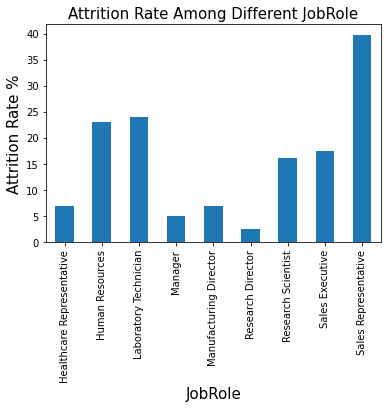

In [73]:
draw_category('JobRole')

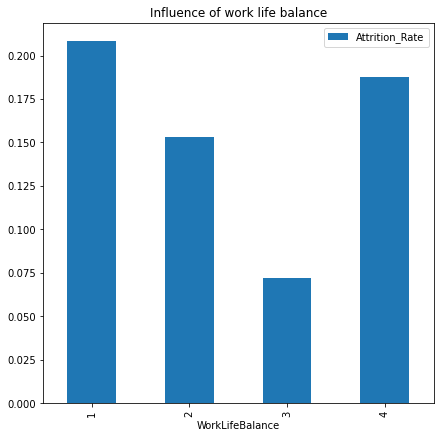

In [74]:
data = df_exp[df_exp['JobSatisfaction']==4]
d = {'WorkLifeBalance' : data['WorkLifeBalance'], 
      'Attrition' : data['Attrition']}
worklife_balance = pd.DataFrame(d) 
worklife_balance_groupby = worklife_balance.groupby(['WorkLifeBalance'])
worklife_balance_groupby = worklife_balance_groupby.sum()
worklife_balance_groupby['Each_Size'] = worklife_balance.groupby(['WorkLifeBalance']).size()
worklife_balance_groupby['Attrition_Rate'] = worklife_balance_groupby.apply(lambda x:x['Attrition']/x['Each_Size'],axis=1)
worklife_balance_groupby.drop(['Attrition','Each_Size'],axis=1).plot(kind='bar',title="Influence of work life balance",figsize=(7,7))

## Data Undersampling

In [75]:
minority_class_len = len(attrition_df[attrition_df['Attrition']==1])
print(minority_class_len)

majority_class_len = len(attrition_df[attrition_df['Attrition']==0])
print(majority_class_len)

majority_indices = attrition_df[attrition_df['Attrition']==0].index
random_majority_indices = np.random.choice(majority_indices, minority_class_len, replace=False)
print(len(random_majority_indices))

minority_indices = attrition_df[attrition_df['Attrition']==1].index
undersample_indices = np.concatenate([minority_indices, random_majority_indices])
df_unders= attrition_df.loc[undersample_indices]

X_under = df_unders.drop('Attrition',axis=1)
y_under = df_unders['Attrition']

print(len(X_under))
print(len(y_under))

237
1233
237
474
474


## Data Oversampling 

In [76]:
from imblearn.over_sampling import SMOTE
def oversampling(X_train, y_train):
    smote = SMOTE(random_state=1)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, y_resampled

## Corss Validation 

In [3]:
def cross_val(X,y,model_selected):
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    model = model_selected
    plt.figure(figsize=(7,7))
    kf = KFold(n_splits=5)
    f_score = []
    ac = []
    precision=[]
    roc=[]
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train = X.iloc[train_index]
        y_train = y[train_index]
        X_test = X.iloc[test_index]
        y_test = y[test_index] 
        sm = SMOTE()
        X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
        model.fit(X_train_oversampled, y_train_oversampled )  
        y_pred = model.predict(X_test)
        probas_ = model.fit(X_train_oversampled, y_train_oversampled ).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append( np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
       
        ac.append(accuracy_score(y_test, y_pred))
        f_score.append(f1_score(y_test, y_pred, average='weighted'))
        precision.append(precision_score(y_test,y_pred,average='weighted'))
        roc.append(roc_auc_score(y_test,y_pred,average='weighted'))
    print(f'f1_score: {sum(f_score)/len(f_score)}')
    print(f'accuracy: {sum(ac)/len(ac)}')
    print(f'precision: {sum(precision)/len(precision)}')
    print(f'auc: {sum(roc)/len(roc)}')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of '+str(model_selected),fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})
    plt.show()

## Logistic Model Construction and Model Evaluation

In [81]:
# Using RFE and p_value to selecting features
def feature_selection(X, y, model_selected, n_feature):
    # RFE feature selection
    rfe = RFE(model_selected,n_feature)
    rfe = rfe.fit(X, y.values.ravel())
    selected = []
    for i in range(len(rfe.support_)):
        if rfe.support_[i] == True:
            selected.append(X.columns[i])
    # fit the first_time selected model
    logit_model=sm.Logit(y,X[selected])
    result=logit_model.fit()
    results_as_html = result.summary().tables[1].as_html()
    # p-value feature selection
    summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]['P>|z|']
    to_drop = []
    for i in range(len(summary_df)):
        if summary_df[i] > 0.05:
            to_drop.append(summary_df.index[i])
    summary_df = summary_df.drop(to_drop)
    selected_2 = summary_df.index
    return selected_2

Optimization terminated successfully.
         Current function value: inf
         Iterations 8
f1_score: 0.7596217675418251
accuracy: 0.7285714285714285
precision: 0.8253444412032671
auc: 0.7039934554041478


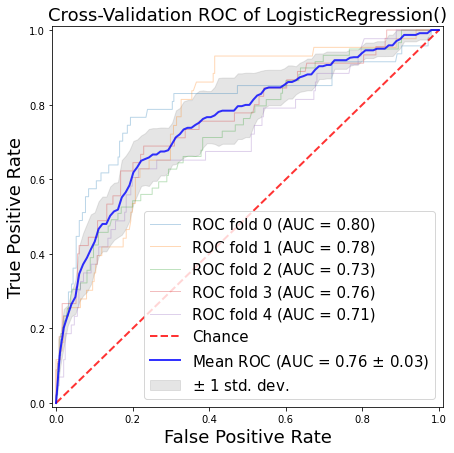

In [82]:
logreg = LogisticRegression()
selected = feature_selection(X, y, logreg, 20)
cross_val(X[selected],y,logreg)

## Lasso Regression Construction and Model Evaluation

In [135]:
# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

# define model
lasso_model = Lasso(alpha=1)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scores = cross_val_score(lasso_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#score = cross_val_score(RDF, X_train, y_train, cv=k_fold, scoring='accuracy')
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.265 (0.021)


In [136]:
# define model
lasso_model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(lasso_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.248
Config: {'alpha': 0.0}


In [137]:
# Therefore we use alpha = 0.01 as the penalty
lasso_model = Lasso(alpha=0.01)


lasso_model.fit(X_test, y_test)

y_pred = lasso_model.predict(X_test)

#cm = confusion_matrix(y_test, y_pred)
#print(confusion_matrix)

## Glmnet Construction and Model Evaluation 

In [138]:
#pip install glmnet

In [60]:
import glmnet_python
from glmnet import glmnet
#fit = glmnet(x = X.copy(), y = y.copy(), family = 'binomial')

ModuleNotFoundError: No module named 'glmnet_python'

## Random Forest Construction and Model Evaluation 

f1_score: 0.8346177779321955
accuracy: 0.8530612244897959
recall: 0.8530612244897959
precision: 0.8337562698878411
auc: 0.6413240004671616


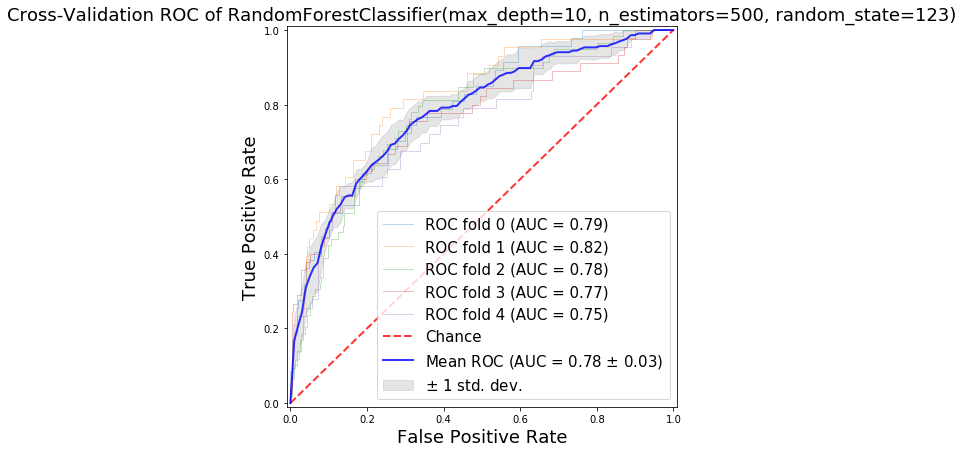

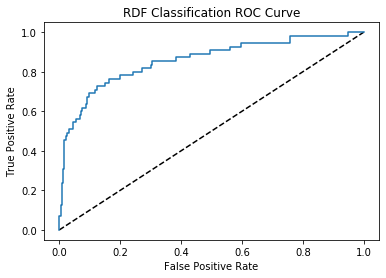

auc_score:  0.8569798402434387


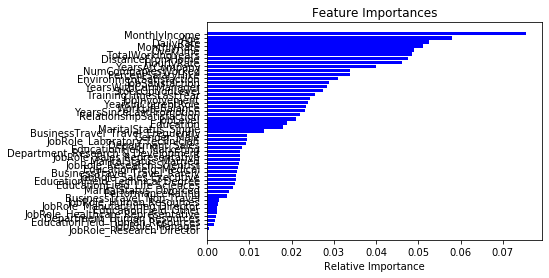

tn:  237
fp:  2
fn:  45
tp:  10
accuracy:  0.8401360544217688
recall:  0.18181818181818182
cv_accuracy_score:  0.8605409304002885
cv_auc_score:  0.797000632427768
cv_recall_score:  0.11531531531531532


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
RDF = RandomForestClassifier(random_state=123, max_depth=10, n_estimators=500)
#cross validation + oversampling
cross_val(X,y,RDF)

RDF.fit(X_train, y_train)
y_pred = RDF.predict(X_test)
y_prob = RDF.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

features = X.columns
importances = RDF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()
print('tn: ',tn)
print('fp: ',fp)
print('fn: ',fn)
print('tp: ', tp)
print('accuracy: ', (tp+tn)/(tn+fp+fn+tp))
print('recall: ', tp/(tp+fn))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

score = cross_val_score(RDF, X_train, y_train, cv=5, scoring='roc_auc')
print('cv_auc_score: ',score.mean())

score = cross_val_score(RDF, X_train, y_train, cv=5, scoring='recall')
print('cv_recall_score: ',score.mean())

## Hyperparameter Tuning using GridSearchCV

In [ ]:
#Hyper-parameter Tuning

#random_grid = {'n_estimators': [100, 200, 300, 500],
               #'max_depth': [5, 10, 20, 30]}

#grid_search = GridSearchCV(estimator = RDF, param_grid = random_grid, 
                          #cv = k_fold, verbose = 1)

#grid_search.fit(X_train, y_train)
#print(print(grid_search.best_params_))

## Using reduced columns based on feature importance to construct a new RDFR Model

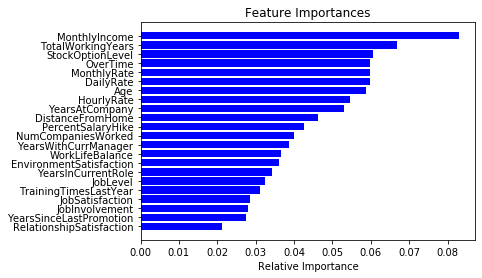

accuracy:  0.6631578947368421
recall:  0.6444444444444445
cv_accuracy_score:  0.7315789473684211
cv_auc_score:  0.7725335606222032
cv_recall_score:  0.6921727395411607


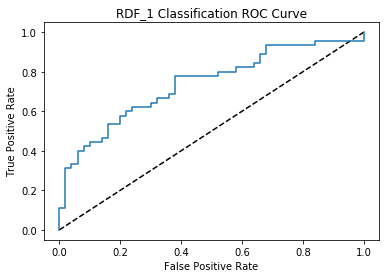

In [157]:
fi_mask = RDF.feature_importances_ > 0.02
X_reduced = X_under.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_under, test_size=0.2, random_state=10)
RDF1 = RandomForestClassifier(random_state=123,max_depth=10, n_estimators=500)
#oversampling
X_train,y_train = oversampling(X_train,y_train)
RDF1.fit(X_train,y_train)
y_pred = RDF1.predict(X_test)
y_prob = RDF1.predict_proba(X_test)[:,-1]


features = X_reduced.columns
importances = RDF1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()
print('accuracy: ', (tp+tn)/(tn+fp+fn+tp))
print('recall: ', tp/(tp+fn))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF1, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

score = cross_val_score(RDF1, X_train, y_train, cv=5, scoring='roc_auc')
print('cv_auc_score: ',score.mean())

score = cross_val_score(RDF1, X_train, y_train, cv=5, scoring='recall')
print('cv_recall_score: ',score.mean())

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF_1 Classification ROC Curve')
plt.show()




## XGBoost

In [ ]:
#pip install xgboost

accuracy:  0.7368421052631579
recall:  0.6888888888888889


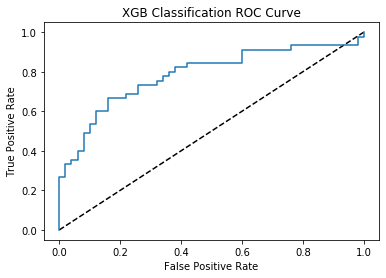

cv_accuracy_score:  0.7082023239917976
cv_auc_score:  0.7953689892748065
cv_recall_score:  0.6970310391363024


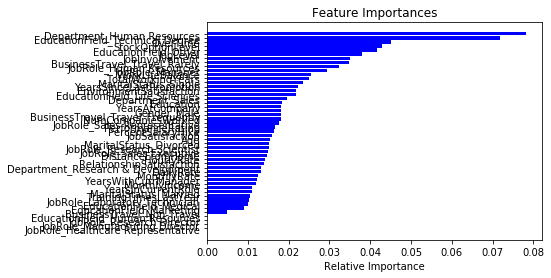

In [143]:
X=attrition_df.drop('Attrition',axis=1)
y=attrition_df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=10)
#oversampling
# X_train,y_train = oversampling(X_train,y_train)


#{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300}
xg_cl=xgb.XGBClassifier(eval_metric='logloss',seed=10,use_label_encoder=False, objective='binary:logistic',
                       colsample_bytree=0.5, learning_rate=0.2, max_depth=8, n_estimators=300)

xg_cl.fit(X_train,y_train)
y_pred=xg_cl.predict(X_test)
y_prob = xg_cl.predict_proba(X_test)[:,1]

cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()
print('accuracy: ', (tp+tn)/(tn+fp+fn+tp))
print('recall: ', tp/(tp+fn))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='XGBClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classification ROC Curve')
plt.show()


k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='roc_auc')
print('cv_auc_score: ',score.mean())

score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='recall')
print('cv_recall_score: ',score.mean())


features = X_under.columns
importances = xg_cl.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#params = {'max_depth':[3,5,8,10],
         #'learning_rate':[0.2, 0.1],
         #'colsample_bytree':[0.5, 0.6, 0.8, 1],
         #'n_estimators':[100, 200, 300]}

#grid_search = GridSearchCV(estimator=xg_cl, param_grid=params, cv=5, verbose=1, scoring='accuracy')

#grid_search.fit(X_train, y_train)

#print(grid_search.best_params_)

## XGBOOST Using Reduced Columns

accuracy:  0.865986394557823
f_score:  0.44968919968919974
recall:  0.34115989268984515
accuracy:  0.6105263157894737
recall:  0.5333333333333333


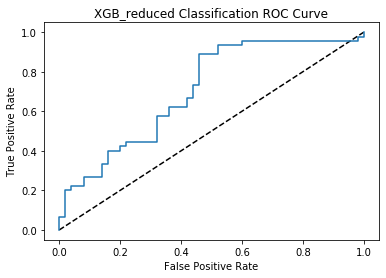

cv_accuracy_score:  0.6701052631578948
cv_auc_score:  0.7208108971959387
cv_recall_score:  0.6398110661268556


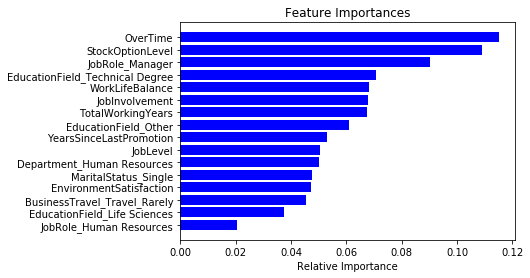

In [142]:
fi_mask = xg_cl.feature_importances_ > 0.02
X_reduced = X_under.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_under, test_size=0.2, random_state=10)
#{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100}
#sampling
# X_train,y_train = oversampling(X_train,y_train)
xg_cl1 = xgb.XGBClassifier(eval_metric='logloss', seed=10,use_label_encoder=False, objective='binary:logistic',
                          colsample_bytree=0.5, learning_rate=0.2, max_depth=8, n_estimators=100)

#cross validation + oversampling
cross_val(X,y,xg_cl1)

xg_cl1.fit(X_train,y_train)
y_pred=xg_cl1.predict(X_test)
y_prob = xg_cl1.predict_proba(X_test)[:,1]

cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()
print('accuracy: ', (tp+tn)/(tn+fp+fn+tp))
print('recall: ', tp/(tp+fn))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='XGBClassifier_reduced')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB_reduced Classification ROC Curve')
plt.show()

features = X_reduced.columns
importances = xg_cl1.feature_importances_
indices = np.argsort(importances)

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='roc_auc')
print('cv_auc_score: ',score.mean())

score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='recall')
print('cv_recall_score: ',score.mean())

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
#params = {'max_depth':[3,5,8,10],
         #'learning_rate':[0.2, 0.1],
         #'colsample_bytree':[0.5, 0.6, 0.8, 1],
         #'n_estimators':[100, 200, 300]}

#grid_search = GridSearchCV(estimator=xg_cl1, param_grid=params, cv=5, verbose=1, scoring='accuracy')

#grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)




# K nearest neighbors

Parameters Tuning

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=5)
# k_range = list(range(1, 31))
# param_grid = dict(n_neighbors=k_range)
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# grid.fit(X, y)
# print(grid.best_score_)
# print(grid.best_params_)
# print(grid.best_estimator_)

f1_score: 0.677706199540504
accuracy: 0.6326530612244898
precision: 0.7599970681443654
auc: 0.5631823907547812


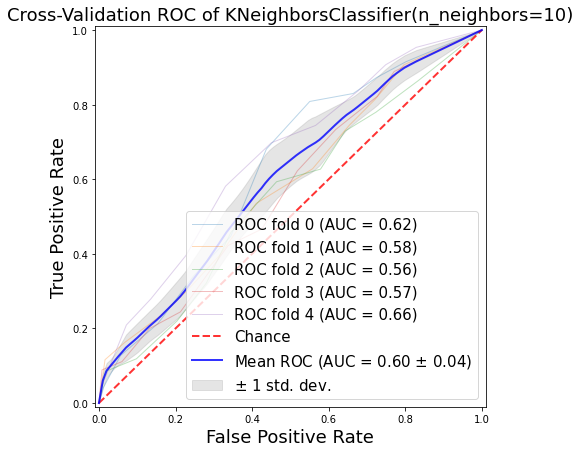

In [4]:
knn = KNeighborsClassifier(n_neighbors=10)
cross_val(X,y,knn)

# Kernel Support Vector Machine with parameters tuning

Parameters Tuning

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
# from sklearn.svm import SVC
# params = {'C':[0.1,1,10,100,1000],
#          'gamma':[0.0001,0.001,0.01,0.1,1],
#          'kernel':['rbf','sigmoid']}

# grid_search = GridSearchCV(SVC(), params)

# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

Radial basis function kernel

f1_score: 0.7743620400026691
accuracy: 0.8285714285714286
precision: 0.7564467412292911
auc: 0.5143840701096526


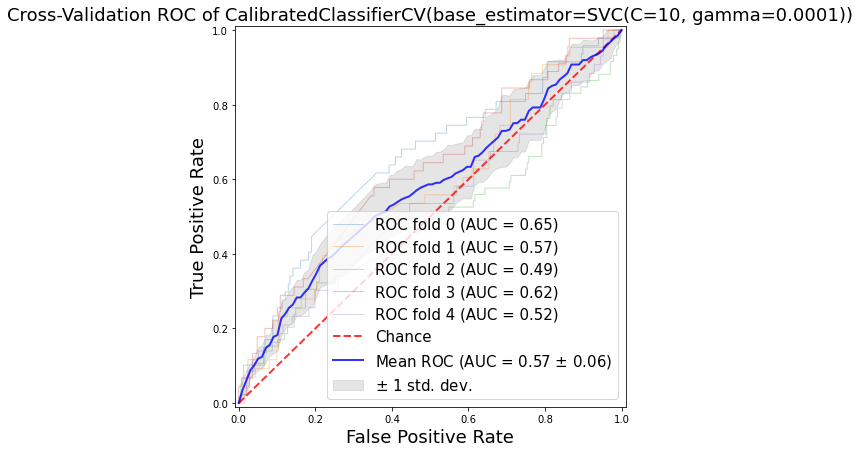

In [5]:
svclassifier = SVC(C=10,gamma=0.0001,kernel='rbf')
clf=CalibratedClassifierCV(svclassifier)
cross_val(X,y,clf)

## Naive Bayes Construction and Model Evaluation 

In [147]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()

#cross validation + oversampling
cross_val(X,y,clf)


# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_prob = clf.predict_proba(X_test)[:,1]

# # redundant code
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# plt.plot([0,1],[0,1],'k--')
# plt.plot(fpr, tpr, label='Bernoulli Naive Bayes Classifier')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Bernoulli Navie Bayes Classification ROC Curve')
# plt.show()
# print(confusion_matrix(y_test,y_pred))
# print('auc_score: ', roc_auc_score(y_test, y_prob))
# print('accuracy', clf.score(X_test,y_test))

f1_score: 0.8044471725813962
accuracy: 0.8
recall: 0.8
precision: 0.8109475209564259
auc: 0.656139730295091


# LightGBM

In [ ]:
# pip install lightgbm

Parameters Tuning

In [ ]:
# params = {'num_leaves':[8,32,128,1024],
#          'max_depth':[3,5,7,10],
#          'min_data_in_leaf':[10,50,100,200,400],
#          'learning_rate':[0.1,0.2],
#          'max_bin':[50,70,90,100],}
# #          'n_estimators':[100, 200, 300,400,500]}

# grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5)

# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

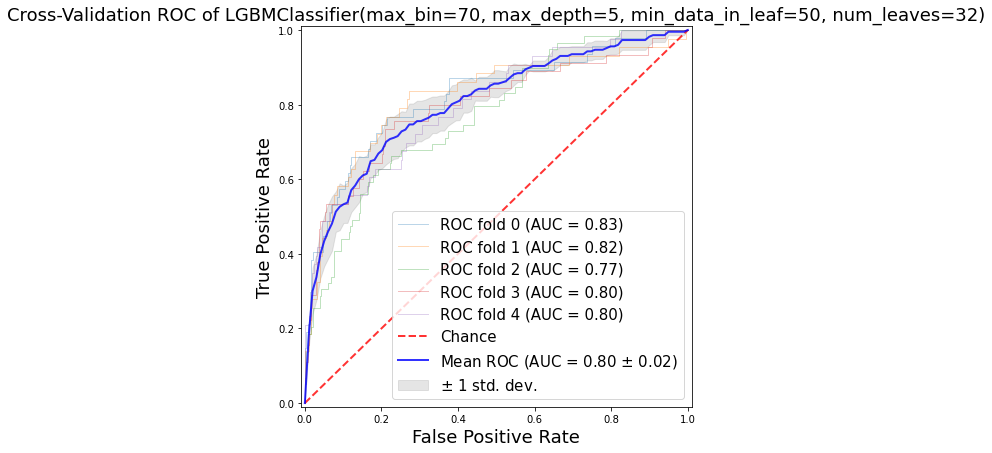

In [6]:
clf = lgb.LGBMClassifier(learning_rate=0.1, max_bin=70, max_depth=5, min_data_in_leaf=50, num_leaves=32)
cross_val(X,y,clf)